In [17]:
# Install poincare in environment
! pip install poincare

# Asymptotic behaviour in Poincare
Poincare contains a number of features to  characterize the asymptotic behaviour of the system, including the search for steady states, bistability and limit cycles for different parameter values.

### Steady States and parameter sweeps
To find steady states, we must first create an instance of the `SteadyState` class.

In [2]:
from poincare import (
    System,
    Variable,
    Derivative,
    Constant,
    Parameter,
    Simulator,
    initial,
    assign,
)
import numpy as np

from poincare import SteadyState
from scipy_events import SmallDerivatives

steady = SteadyState(t_end=1000)

The solver can be changed from the default LSODA by passing a `solver` attribute in a way similar to `Simulator.solve()` (see above). The `SteadyState.solve()` method runs the simulator until it finds a steady states (the derivatives are small enough) or it reaches `t_end`. Since  the default for `t_end` is `np.inf`, not changing it may result in the `Simulator.solve()` running indefinitely.

In [3]:
# Create a system
class Pitchfork(System):
    x: Variable = initial(default=1)

    r: Parameter = assign(default=1)

    eq = x.derive() << r * x - x**3


# Create a Simulator for Bistable
sim = Simulator(Pitchfork)
# Find steady state
steady.solve(sim, values={Pitchfork.r: 2})

time     1.472048
x        1.412065
event           0
Name: 0, dtype: object

It outputs a pandas `Series` the steady state reached for each variable and the time at which it terminated. `0` in the event column indicates it terminated correctly, if it reaches `t_end` without terminating it outputs `NA`.

The `SteadyState.sweep()` method allows for parameter sweeps, finding the steady state with each parameter:

<Axes: xlabel='r'>

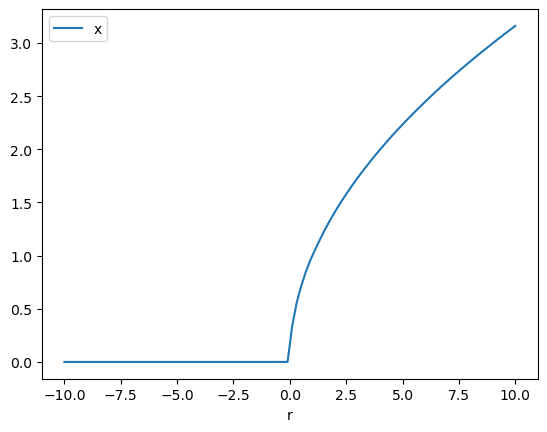

In [4]:
steady.sweep(sim, variable=Pitchfork.r, values=np.linspace(-10, 10, 100)).drop(
    columns=["time", "event"]
).plot()

Since `values` only takes the values of the parameter to sweep, changes to initial conditions or values for other parameters in a sweep, must be done at simulator creation level: 

In [5]:
sim_p = Simulator(Pitchfork(x=-1))
steady.sweep(sim_p, variable=Pitchfork.r, values=np.linspace(-10, 10, 100)).drop(
    columns=["time", "event"]
)

,x
r,
-10.000000,-6.942388e-07
-9.797980,-7.028369e-07
-9.595960,-7.118430e-07
-9.393939,-7.212867e-07
-9.191919,-7.312004e-07
...,...
9.191919,-3.030849e+00
9.393939,-3.063973e+00
9.595960,-3.096750e+00


We can also use `StadyState.sweep_up_and_down()`, which sweeps first up and then down through `values` setting the steady state found in each run as initial conditions for the next.

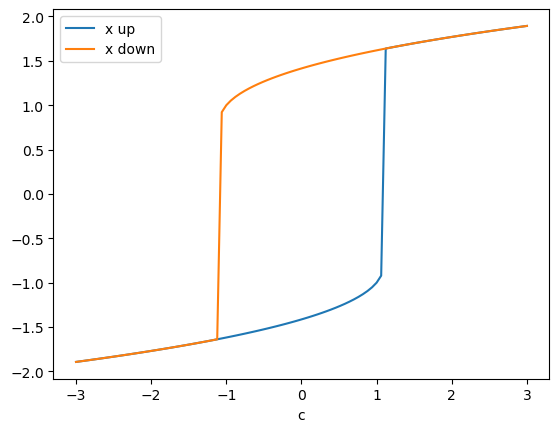

In [6]:
class BiasedDouble(System):
    x: Variable = initial(default=-2)
    v: Derivative = x.derive(initial=0)

    c: Parameter = assign(default=1)

    eq = v.derive() << -v - x**3 + 2 * x + c


sim2 = Simulator(BiasedDouble)
result2 = steady.sweep_up_and_down(
    sim2, variable=BiasedDouble.c, values=np.linspace(-3, 3, 100)
).drop(columns=["time", "event", "v"])

# Make bistability plot
ax = result2.xs("up", level="direction").plot()
result2.xs("down", level="direction").plot(ax=ax)
ax.legend(["x up", "x down"])


Poincare also allows for the search of bistability with different parameters:

In [7]:
steady.bistability(sim2, variable=BiasedDouble.c, values=np.arange(-3, 3.1, 1)).drop(
    columns="v"
)

,x
c,
-3.0,False
-2.0,False
-1.0,True
0.0,True
1.0,True
2.0,True
3.0,False


`SteadyState.bistability()` works by sweeping up and down and checking if the difference between the up and down value is either greater than the absolute tolerance or greater then the sum of the results times the relative tolerance. These can be changed manually by passing `atol` and `rtol` respectively as parameters:

In [8]:
steady.bistability(
    sim2, variable=BiasedDouble.c, values=np.arange(-3, 3.1, 1), atol=0.1, rtol=0.01
).drop(columns="v")

,x
c,
-3.0,False
-2.0,False
-1.0,True
0.0,True
1.0,True
2.0,False
3.0,False


### Limit cycle analysis
If systems seem to stabilize around a limit cycle instead of reaching a steady state, we can use the `Oscillations` class to find it's period and amplitude. By default it uses the [Autoperiod](https://epubs.siam.org/doi/epdf/10.1137/1.9781611972757.40) method with an implementation based on the one in the [Periodicity Detection](https://pypi.org/project/periodicity-detection/) package.

In [9]:
from poincare import Oscillations

osc = Oscillations()

It allows for parameter sweeps using the `Oscillations.sweep()` method, which takes a simulator for the `System` as its first argument:

In [10]:
from poincare import Independent
from symbolite import scalar


# Create a System wich represents a sinusodally forced harmonic oscillator
class ForcedDampedOscillator(System):
    t = Independent()
    # Define new external variables for the sysyem
    x: Variable = initial(default=1)
    vx: Derivative = x.derive(initial=0)

    spring_constant: Parameter = assign(default=2)
    damp_rate: Parameter = assign(default=0.3)
    omega: Parameter = assign(default=0.5)
    force: Parameter = assign(default=0.2 * scalar.sin(omega * t))

    # Apply the models to the external systems variables
    oscillator = vx.derive() << -spring_constant * x + force + 0.2
    dampening = vx.derive() << -damp_rate * vx


# Create a simulator for the system
sim3 = Simulator(ForcedDampedOscillator)

# Sweep parameters
result3 = osc.sweep(
    sim3,
    T_min=1.5,
    T_max=20,
    T_r=100,
    parameter=ForcedDampedOscillator.omega,
    values=np.linspace(1, 2, 20),
)
result3.head(3)

,period,amplitude,difference_rms
omega,,,
1.000000,6.3,0.191476,0.002300
1.052632,6.0,0.211159,0.004858
1.105263,5.7,0.236166,0.002840


Besides the simulator, `Oscillations.sweep()` takes the following required keyword arguments:
- `T_min`/`T_max`: minimum of maximum of range in which periods are expected to be found.
- `T_r`: upper bound for the system's relaxation time , after which it is expected to be close enough to it's limit cycle.
- `parameter`: parameter to sweep in.
- `values`: iterable of values which `parameter` will take.

To determine `T_min`, `T_max` and `T_r` it is generally a reasonable first estimate to assume monotonicity with respect to the parameter, so we can simulate in it's maximum and minimum value and use the largest (or smallest for `T_min`) result obtained.

The output is a pandas `DataFrame` which contains period, amplitude and mean quadratic difference between consecutive periods indexed by the swept parameter's value. We can plot the results for period and amplitude:

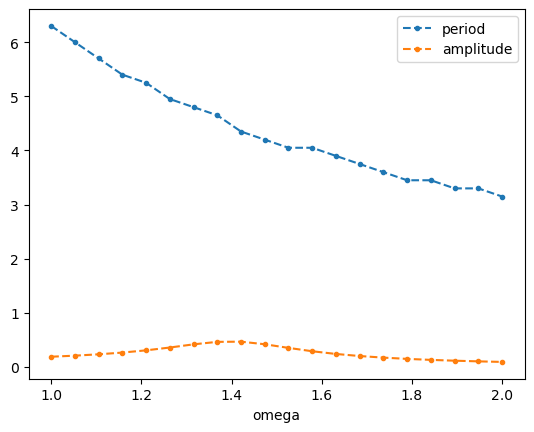

In [11]:
from matplotlib import pyplot as plt

result3["period"].plot(style="--.")
result3["amplitude"].plot(style="--.")
plt.legend()

And get an idea of how accurate the estimate is by plotting the mean quadratic difference between periods relative to the amplitude:

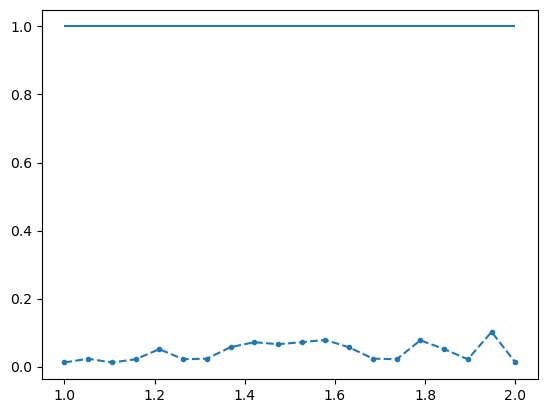

In [12]:
plt.plot(result3.index, result3["difference_rms"] / result3["amplitude"], "--.")
plt.hlines(1, 1, 2)

If the method fails to find or confirm a period it will raise warnings:

In [13]:
result = osc.sweep(
    sim3,
    T_min=2,
    T_max=35,
    T_r=100,
    parameter=ForcedDampedOscillator.omega,
    values=np.linspace(0.2, 3, 20),
)
result.head(3)

C:\Users\olive\Pasantia\poincare\src\poincare\simulator.py:496: UserWarning: could not verifiy period for x with omega = 0.34736842105263155, returning period with maximum power
  warn(


,period,amplitude,difference_rms
omega,,,
0.200000,31.4,0.102002,0.000236
0.347368,18.6,0.106239,0.013304
0.494737,12.6,0.113373,0.003977


We can try changing the minimum amount of periods it simulates after relaxation `T_after_rel` or the minimum amount of timesteps after integration in `Dt_in_T` to get a better result:

In [14]:
result = osc.sweep(
    sim3,
    T_min=2,
    T_max=35,
    T_r=100,
    parameter=ForcedDampedOscillator.omega,
    values=np.linspace(0.2, 3, 20),
    T_after_rel=15,
    Dt_in_T=5,
)
result.head(3)

,period,amplitude,difference_rms
omega,,,
0.200000,31.2,0.101961,0.003115
0.347368,18.0,0.106170,0.002295
0.494737,12.8,0.113269,0.003970


If the System has more than one variable `Oscillations.sweep`, will by default look at all of them, finding a period and amplitude for each:

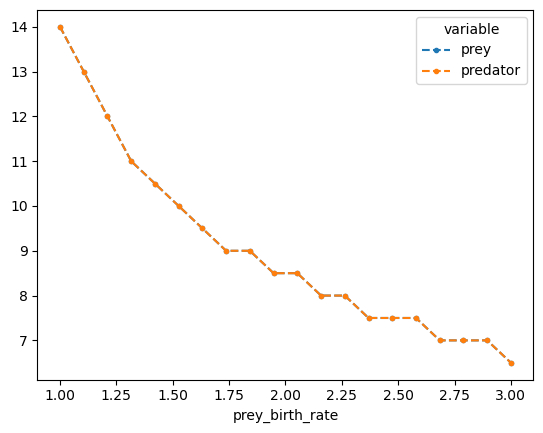

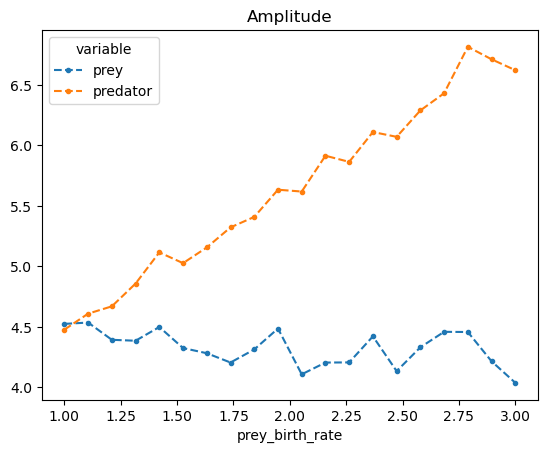

Text(0.5, 1.0, 'relative difference rms')

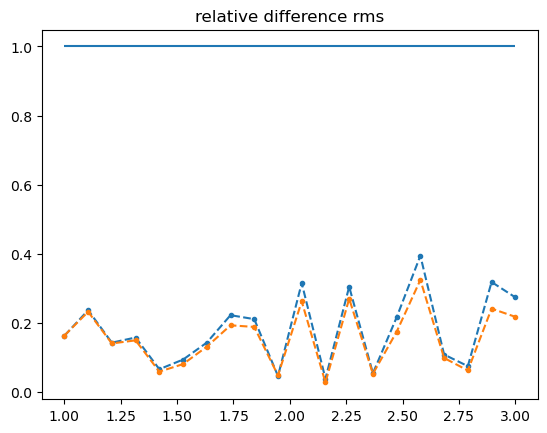

In [15]:
class LotkaVolterra(System):
    prey: Variable = initial(default=10)
    predator: Variable = initial(default=1)

    prey_birth_rate: Parameter = assign(default=1)
    prey_death_rate: Parameter = assign(default=1)
    predator_death_rate: Parameter = assign(default=1)
    predator_birth_rate: Parameter = assign(default=1)
    k: Parameter = assign(default=1)

    birth_prey = prey.derive() << prey_birth_rate * prey
    death_prey = prey.derive() << -prey_death_rate * prey * predator

    birth_predator = predator.derive() << predator_birth_rate * prey * predator
    death_predator = predator.derive() << -predator_death_rate * predator


sim4 = Simulator(LotkaVolterra)

result = osc.sweep(
    sim4,
    T_min=5,
    T_max=20,
    T_r=100,
    parameter=LotkaVolterra.prey_birth_rate,
    values=np.linspace(1, 3, 20),
    T_after_rel=10,
    Dt_in_T=10,
)
result.xs("period", axis=1, level="quantity").plot(style="--.")
plt.show()
result.xs("amplitude", axis=1, level="quantity").plot(style="--.")
plt.title("Amplitude")
plt.show()
plt.plot(
    result.index,
    result[("prey", "difference_rms")] / result[("prey", "amplitude")],
    "--.",
)
plt.plot(
    result.index,
    result[("predator", "difference_rms")] / result[("predator", "amplitude")],
    "--.",
)
plt.hlines(1, 1, 3)
plt.title("relative difference rms")


Or we can specifically pass a list `variables` specifying which should be considered:

In [16]:
result5 = osc.sweep(
    sim4,
    T_min=5,
    T_max=20,
    T_r=100,
    parameter=LotkaVolterra.prey_birth_rate,
    values=np.linspace(1, 3, 20),
    T_after_rel=10,
    Dt_in_T=10,
    variables=[LotkaVolterra.prey],
)
result5.head(3)

,period,amplitude,difference_rms
prey_birth_rate,,,
1.000000,14.0,4.524639,0.732561
1.105263,13.0,4.535702,1.070817
1.210526,12.0,4.393105,0.623824
